# Imports

In [73]:
import os
import numpy as np
import librosa
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import plotly.figure_factory as ff
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Download Data

In [38]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("piyushagni5/berlin-database-of-emotional-speech-emodb")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/berlin-database-of-emotional-speech-emodb


In [39]:
DATA_PATH = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/'

# Emotion code mapping
emotion_map = {
    'W': 'angry', 'L': 'boredom', 'E': 'disgust',
    'A': 'fear', 'F': 'happy', 'T': 'sad', 'N': 'neutral'
}

# ✅ Augmentation functions

In [40]:

def add_noise(y):
    return y + 0.005 * np.random.randn(len(y))

def apply_augmentation(y, sr):
    if random.random() < 0.5:
        y = add_noise(y)
    if random.random() < 0.5:
        y = librosa.effects.pitch_shift(y=y,sr= sr, n_steps=random.uniform(-1, 1))
    if random.random() < 0.5:
        y = librosa.effects.time_stretch(y, rate=random.uniform(0.9, 1.1))
    return y


# ✅ Feature Extractor: MFCC + Delta + Delta²


In [41]:
def extract_features(file_path, max_len=160):
    y, sr = librosa.load(file_path, duration=4, offset=0.5)
    y = apply_augmentation(y, sr)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    combined = np.vstack([mfcc, delta, delta2]).T  # shape: (T, 60)

    if combined.shape[0] < max_len:
        pad_len = max_len - combined.shape[0]
        combined = np.pad(combined, ((0, pad_len), (0, 0)), mode='constant')
    else:
        combined = combined[:max_len, :]
    return combined

# ✅ Load dataset


In [42]:

features, labels = [], []

for file in os.listdir(DATA_PATH):
    if file.endswith('.wav'):
        emo_code = file[5]
        if emo_code in emotion_map:
            emotion = emotion_map[emo_code]
            path = os.path.join(DATA_PATH, file)
            feat = extract_features(path)
            features.append(feat)
            labels.append(emotion)

# ✅ Prepare data


In [43]:
X = np.array(features)  # shape: (samples, 160, 60)
le = LabelEncoder()
y = le.fit_transform(labels)
y_cat = to_categorical(y)

# ✅ Class weights for imbalance


In [44]:

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

# ✅ Train/Test split


In [45]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, stratify=y_cat, test_size=0.2, random_state=42)


# ✅ Callbacks


In [46]:

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ✅ BiLSTM model


In [47]:
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),  # (160, 60)
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(128)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train



In [49]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16,
          validation_data=(X_test, y_test),
          class_weight=class_weight_dict,
          callbacks=[lr_scheduler,early_stop],
          verbose=1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9953 - loss: 0.0342 - val_accuracy: 0.6916 - val_loss: 1.2780 - learning_rate: 1.0000e-05
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9918 - loss: 0.0397 - val_accuracy: 0.6916 - val_loss: 1.2967 - learning_rate: 1.0000e-05
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9967 - loss: 0.0260 - val_accuracy: 0.7009 - val_loss: 1.2945 - learning_rate: 1.0000e-05
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 0.0338 - val_accuracy: 0.6916 - val_loss: 1.2941 - learning_rate: 1.0000e-05
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 0.0277 - val_accuracy: 0.7009 - val_loss: 1.2908 - learning_rate: 1.0000e-05
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 0.0246 - val_accuracy: 0.6916 - val_loss: 1.3070 - learning_rate: 1.0000e-05
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 

# ✅ Evaluate


In [50]:

loss, acc = model.evaluate(X_test, y_test)
print(f"\n🎯 Final Test Accuracy: {acc * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7068 - loss: 1.1886

🎯 Final Test Accuracy: 69.16%


# ✅ Random Sample Prediction


In [51]:

for i in range(10):
 idx = random.randint(0, len(X_test) - 1)
 sample = X_test[idx].reshape(1, X.shape[1], X.shape[2])
 true_label = le.inverse_transform([np.argmax(y_test[idx])])[0]
 predicted_label = le.inverse_transform([np.argmax(model.predict(sample))])[0]
 print(f"✅ True: {true_label} | 🔍 Predicted: {predicted_label}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
✅ True: angry | 🔍 Predicted: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
✅ True: boredom | 🔍 Predicted: boredom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
✅ True: fear | 🔍 Predicted: disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
✅ True: neutral | 🔍 Predicted: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
✅ True: boredom | 🔍 Predicted: boredom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
✅ True: boredom | 🔍 Predicted: boredom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
✅ True: sad | 🔍 Predicted: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
✅ True: fear | 🔍 Predicted: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
✅ True: angry | 🔍 Predicted: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
✅ True: happy | 🔍 Predicted: happy


# ✅ Save model


In [52]:
model.save("emotion_bilstm_final_model.keras")
print("✅ Model saved as 'emotion_bilstm_final_model.keras'")

✅ Model saved as 'emotion_bilstm_final_model.keras'


# Ploting Functions

In [64]:


def plot_history(history):
    plt.style.use('ggplot') # Changed style to 'ggplot'
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axs[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axs[0].set_title("📈 Accuracy over Epochs")
    axs[0].set_xlabel("Epochs"); axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    axs[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axs[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axs[1].set_title("📉 Loss over Epochs")
    axs[1].set_xlabel("Epochs"); axs[1].set_ylabel("Loss")
    axs[1].legend()
    plt.tight_layout(); plt.show()



def plotly_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    fig = ff.create_annotated_heatmap(z=cm.tolist(), x=labels, y=labels, colorscale='Blues')
    fig.update_layout(title_text='Interactive Confusion Matrix', xaxis_title='Predicted', yaxis_title='Actual')
    fig.show()

def class_accuracy_plot(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, output_dict=True, target_names=labels)
    precisions = [report[label]['precision'] for label in labels]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=labels, y=precisions, palette='magma')
    plt.ylim(0, 1.0)
    plt.title("🎯 Precision per Emotion Class"); plt.ylabel("Precision"); plt.xlabel("Emotion")
    plt.show()
def plot_emotion_distribution(labels, title="Emotion Distribution"):
    emotion_series = pd.Series(labels)
    plt.figure(figsize=(10, 5))
    sns.countplot(x=emotion_series, palette='coolwarm', order=emotion_series.value_counts().index)
    plt.title(f"📊 {title}", fontsize=14)
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_waveform_and_mfcc(filepath):
    y, sr = librosa.load(filepath)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title("🎵 Waveform")

    plt.subplot(1, 2, 2)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.title("🎧 MFCC (20 Coefficients)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
def plot_tsne_features(X, y, labels, method='tsne'):
    flat_X = X.reshape(X.shape[0], -1)
    reducer = TSNE(n_components=2, random_state=42) if method == 'tsne' else PCA(n_components=2)
    reduced = reducer.fit_transform(flat_X)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=[labels[i] for i in np.argmax(y, axis=1)],
                    palette='Set2', s=60)
    plt.title(f"🎯 {method.upper()} Projection of Emotion Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 📉 Plotly Confusion Matrix

In [65]:
y_pred_raw = model.predict(X_test)
y_pred = le.inverse_transform(np.argmax(y_pred_raw, axis=1))
y_true = le.inverse_transform(np.argmax(y_test, axis=1))

plotly_confusion_matrix(y_true, y_pred, le.classes_.tolist())

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


# 📌 Class Precision Bar Plot


/tmp/ipython-input-64-3881177251.py:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.



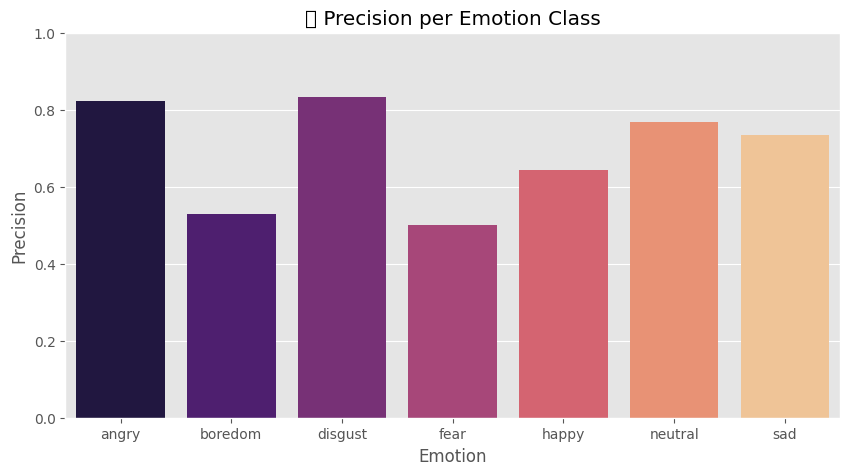

In [66]:
class_accuracy_plot(y_true, y_pred, le.classes_)


# 📈 Accuracy & Loss


/tmp/ipython-input-64-3881177251.py:15: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-64-3881177251.py:15: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.



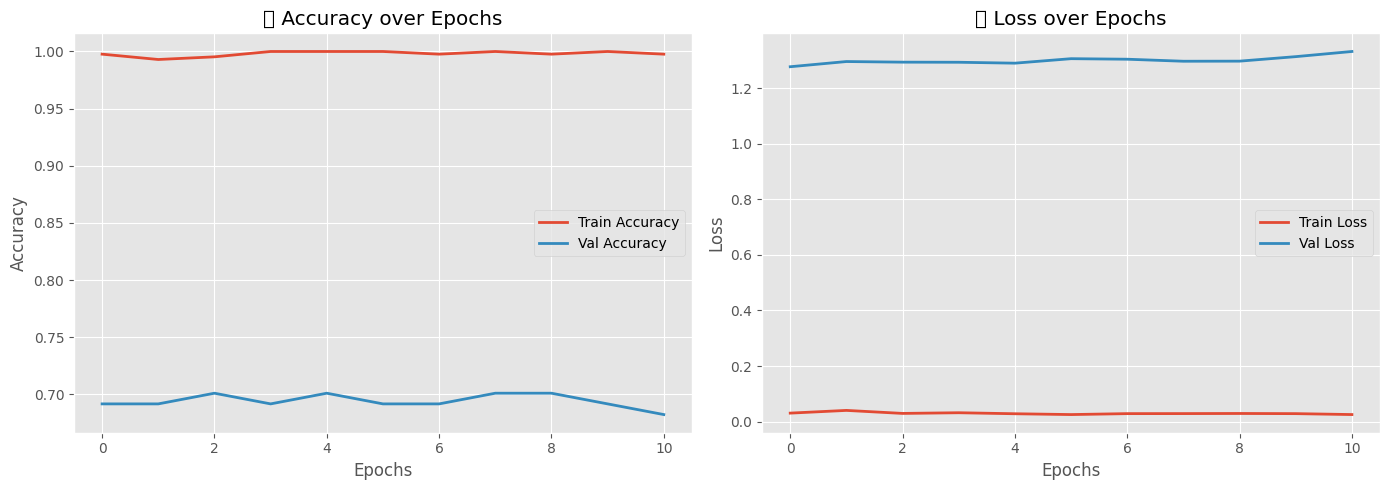

In [67]:
plot_history(history)

# 📉 Emotion Distribution

/tmp/ipython-input-68-906357866.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-68-906357866.py:9: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



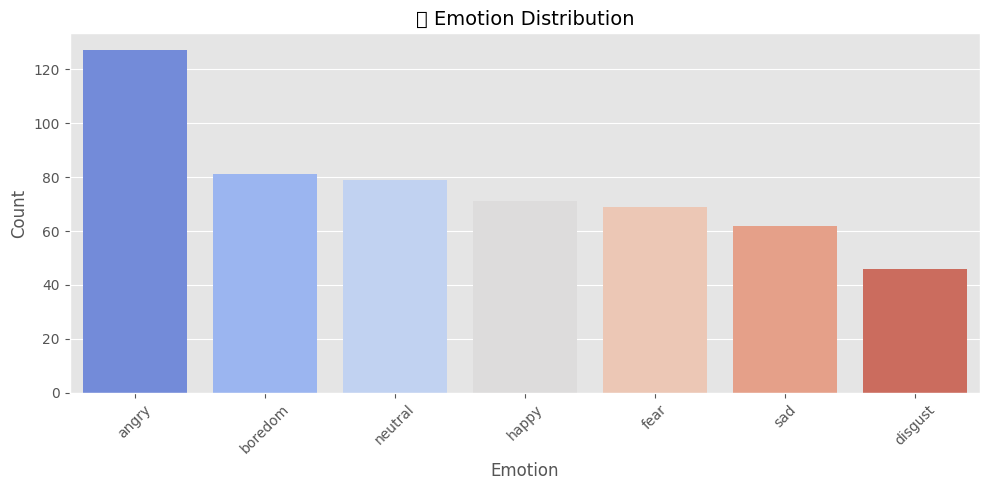

In [68]:


plot_emotion_distribution(labels)


# 📉 Waveform and Mfcc

/tmp/ipython-input-69-172817966.py:14: UserWarning:

Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.

/tmp/ipython-input-69-172817966.py:14: UserWarning:

Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.



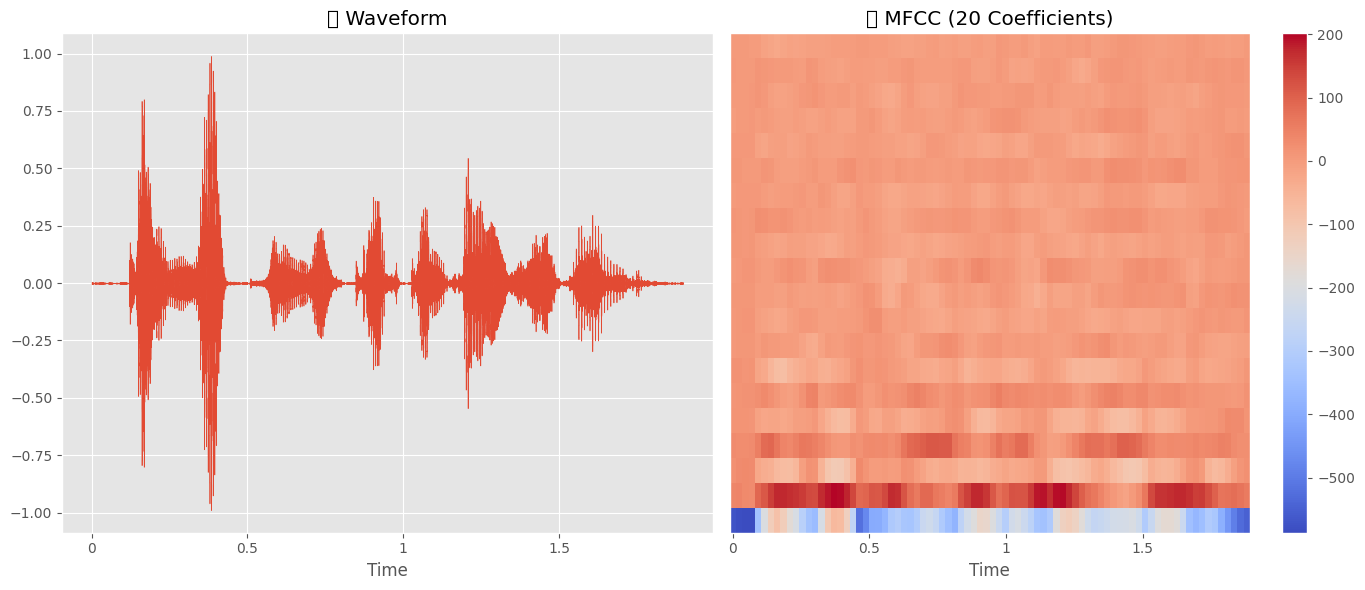

In [69]:

plot_waveform_and_mfcc('/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/03a01Fa.wav')  # Example file


# 📉 TSNE features

/tmp/ipython-input-72-3611318760.py:16: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.



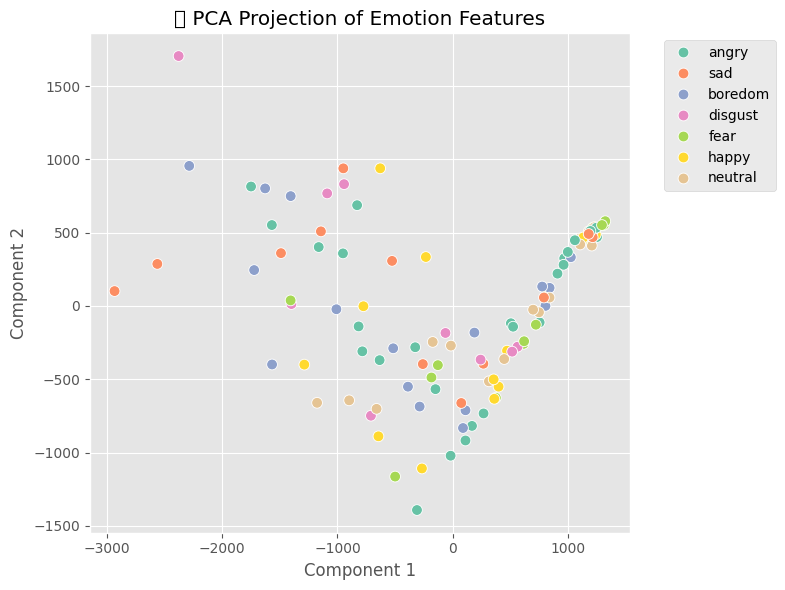

In [72]:

plot_tsne_features(X_test, y_test, le.classes_, method='pca')

